In [1]:
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

com_class = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
rec_class = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
all_class = com_class + rec_class

exclude_sign = "~#$%^&*()[]{}<>|+=1234567890"
replace_sign = "@,.?!-;"

In [2]:
def preprocessing(data):
    ans = []
    for i in range(len(data)):
        sentence = data[i]
        for c in exclude_sign:
            sentence = sentence.replace(c, "")
        for c in replace_sign:
            sentence = sentence.replace(c, " ")
        ans.append(sentence)
    return ans

def plot_contingency_matrix(cm, x_labels, y_labels, title, cmap = plt.cm.BuPu):
    plt.figure(figsize=(12,9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    plt.title(title, fontsize = 22)
    plt.colorbar()
    xlocations = np.array(range(len(x_labels)))
    plt.xticks(xlocations, x_labels)
    plt.yticks(xlocations, y_labels)
    tick_array = np.arange(len(x_labels))
    x, y = np.meshgrid(tick_array, tick_array)
    for i, j in zip(x.flatten(), y.flatten()):
        plt.text(j, i, cm[i][j], ha = "center", va = "center", color = "black", fontsize = 24)
    plt.ylabel('Classes', fontsize = 18)
    plt.xlabel('Clusters', fontsize = 18)
    #fig = plt.gcf()
    plt.show()

In [3]:
def perform_kmeans(kmeans, data, Y, r):
    kmeans.fit(data)
    contingency = contingency_matrix(Y, kmeans.labels_)
    classes = ["Class 1", "Class 2"]
    clusters = ["Cluster 1", "Cluster 2"]
    plot_contingency_matrix(contingency, clusters, classes, "contingency matrix for r = " + str(r))
    print('Homogeneity:', metrics.homogeneity_score(Y, kmeans.labels_))
    print('Completeness:', metrics.completeness_score(Y, kmeans.labels_))
    print('V-measure:', metrics.v_measure_score(Y, kmeans.labels_))
    print('Adjusted Rand Score:', metrics.adjusted_rand_score(Y, kmeans.labels_))
    print('Adjusted Mutual Info Score:', metrics.adjusted_mutual_info_score(Y, kmeans.labels_))
    print('')

In [4]:
def plot_result(X, Y_real, Y_clusters, centers, title):
    plt.figure(figsize = (12, 9))
    plt.title(title)
    colors = ["yellow", "green"]
    markers = ['o', 'x']
    for i in range(len(X)):
        if Y_real[i] == 0:
            if Y_clusters[i] == 0:
                plt.scatter(X[i, 0], X[i, 1], s = 15, marker = markers[0], color = colors[0])
            elif Y_clusters[i] == 1:
                plt.scatter(X[i, 0], X[i, 1], s = 15, marker = markers[1], color = 'red')
        
        elif Y_real[i] == 1:
            if Y_clusters[i] == 1:
                plt.scatter(X[i, 0], X[i, 1], s = 15, marker = markers[1], color = colors[1])
            elif Y_clusters[i] == 0:
                plt.scatter(X[i, 0], X[i, 1], s = 15, marker = markers[0], color = 'blue')
    
    for i in range(2):
        plt.scatter(centers[i, 0], centers[i, 1], marker='+', s=150, linewidths=20, color='black')
    fig = plt.gcf()
    plt.show()
    fig.savefig('visual.png', dpi=300, bbox_inches = 'tight')
    
    
    

In [5]:
all_data = fetch_20newsgroups(subset='all', categories=all_class, shuffle=True, random_state=42)
# 1 represent "recreational activity", 0 represent "computer classes"
Y = [0] * len(all_data.target)
for i in range(len(Y)):
    if all_data.target[i] >= 4:
        Y[i] = 1

trim_all_data = preprocessing(all_data.data)
count_vectorizer = CountVectorizer(min_df=3, stop_words='english')
tfidf_transformer = TfidfTransformer()

X_count = count_vectorizer.fit_transform(trim_all_data)
X_tfidf = tfidf_transformer.fit_transform(X_count)
print (X_tfidf.shape)

(7882, 23825)


In [6]:
svd = TruncatedSVD(n_components=2, n_iter=10, random_state=42)
X_SVD = svd.fit_transform(X_tfidf)

nmf = NMF(n_components=2, init='random', random_state=0)
X_NMF = nmf.fit_transform(X_tfidf)

In [7]:
print(X_SVD.shape)
print(X_NMF.shape)

(7882, 2)
(7882, 2)


In [8]:
kmeans_LSI = KMeans(n_clusters=2, max_iter = 1000, n_init = 30, random_state=0)

In [9]:
kmeans_LSI.fit(X_SVD)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=2, n_init=30, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

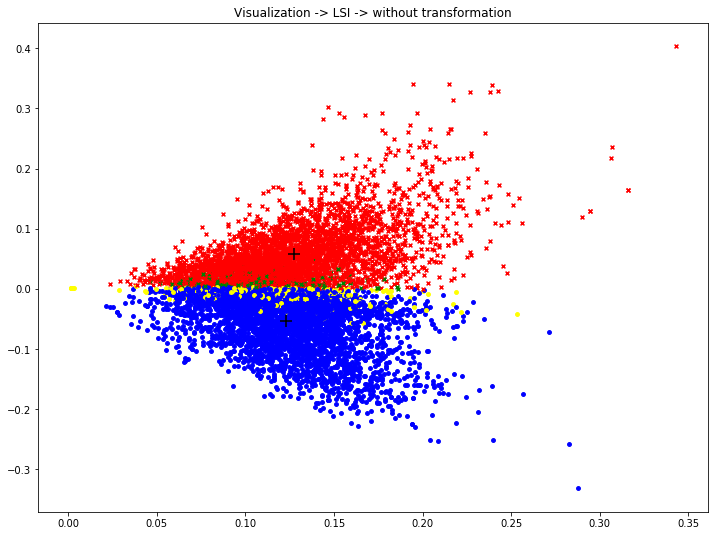

In [10]:
Y_clusters = kmeans_LSI.labels_
centers = kmeans_LSI.cluster_centers_
plot_result(X_SVD, Y, Y_clusters, centers, "Visualization -> LSI -> without transformation")

In [11]:
kmeans_NMF = KMeans(n_clusters = 2, max_iter = 1000, n_init = 30, random_state=0)
kmeans_NMF.fit(X_NMF)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
       n_clusters=2, n_init=30, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

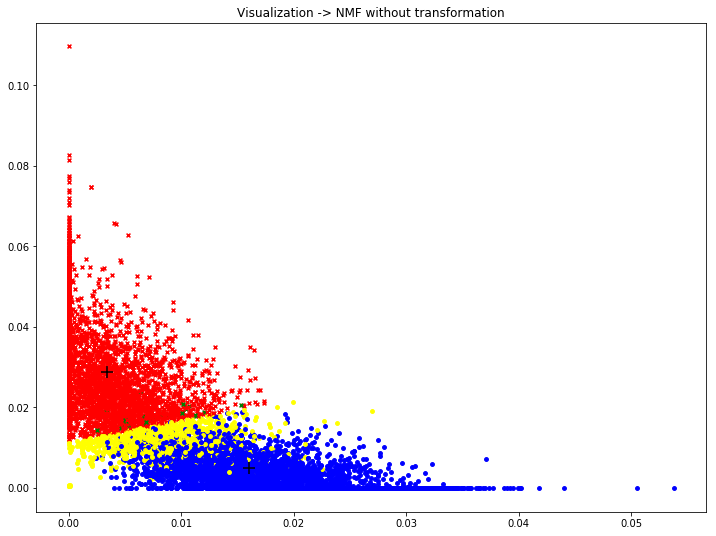

In [13]:
Y_clusters = kmeans_NMF.labels_
centers = kmeans_NMF.cluster_centers_
plot_result(X_NMF, Y, Y_clusters, centers, "Visualization -> NMF without transformation")